# AS - TME2
---
2018-2019

BINOME : Juliette ORTHOLAND, Stieban FERNANDEZ

## Modèle linéaire

Librairies utiles

In [1]:
import pandas as pd
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Implémentation du module et du coût

In [2]:
class Module:
    def forward(self, x):
        ## Calcule la sortie
        pass
    
    def  backward_update_gradient(self, x, delta):
        ## Gradient du module par  rapport  aux parametres
        ## et  mise a jour du  gradient
        pass
    
    def update_parameters (self, epsilon):
        ## Mise a jour  des  parametres
        pass
    
    def backward_delta (self, x, delta):
        ## Retourne  l e  gradient  du module par  rapport  aux  entrees
        pass
    
    def zero_grad(self):
        ## Remise a zero du  gradient    
        pass
    
    def  initialize_parameters(self):
        ### Initialisation des parametres
        pass
    
    
class Loss:
    def forward(self, y, ypred):
        ## Calcule l'erreur
        pass
    
    def backward(self, y, ypred):
        ## Gradient du cout
        pass

    
class FunctionLinear:
    @staticmethod
    def forward( x, w):
        return torch.mm(x,w)  
    
    @staticmethod
    def backward(delta, x, w):
        #to check formula
        grad_x = torch.mm(delta, w.t())
        grad_w = torch.mm(x.t(),delta)
        return grad_x,grad_w


class ModuleLinear(Module):
    def __init__(self, _in, out):
        #in : dimension de l'entrée
        #out : dimension de la sortie
        self.w = torch.rand(_in, out)
        self.grad = torch.zeros(_in, out)
        
    def forward(self, x):
        return FunctionLinear.forward(x, self.w)  
    
    def backward_update_gradient(self, x, delta):
        self.grad += FunctionLinear.backward(delta, x, self.w)[1]
    
    def backward_delta(self, x, delta):
        return torch.mm(delta, self.w.t())
    
    def update_parameters(self, epsilon):
        self.w = self.w - epsilon*self.grad
    
    def zero_grad(self):
        self.grad.zero_()
        
        
class MSE(Loss):
    # Cout MSE
    def forward(self, y, ypred):
        return 0.5*(ypred - y).pow(2).sum()

    def backward(self, y, ypred):
        return ypred - y
    
class Hinge(Loss):
    # Cout Hinge loss
    def forward(self, y, ypred):
        return np.maximum(0, -y*ypred).sum()

    def backward(self, y, ypred):
        return -y
    

---
## Régression linéaire

### Jeu de données aléatoire et test
Test avec jeu de données créé à la main

In [3]:
X, Y = torch.rand(100,2), torch.rand(100).reshape(-1,1)

In [6]:
model = ModuleLinear(2,1)
loss = MSE()

model.zero_grad()
ypred = model.forward(X)
delta = loss.backward(Y, ypred)

model.backward_update_gradient(X, delta)
model.update_parameters(epsilon=0.005)
print(loss.forward(Y, ypred))

ypred = model.forward(X)
print(loss.forward(Y, ypred))

tensor(6.5744)
tensor(6.5350)


Implémentation des trois variantes pour la descente de gradient :

- Stochastique
- Batch
- Minibatch

### Stochastique

In [11]:
def stochastique(X, Y, module, loss=MSE(), epsilon=0.0001, max_iter=100):
    cout = []
    for i in range(max_iter):
        inds = list(range(len(X)))
        np.random.shuffle(inds)
        for x, y in zip(X[inds], Y[inds]):
            x, y = x.reshape(1, -1), y.reshape(1,-1)
            module.zero_grad()
            ypred = module.forward(x)
            delta = loss.backward(y, ypred)
            
            module.backward_update_gradient(x, delta)
            module.update_parameters(epsilon=epsilon)
            
            cout.append(loss.forward(y, ypred))
    return cout

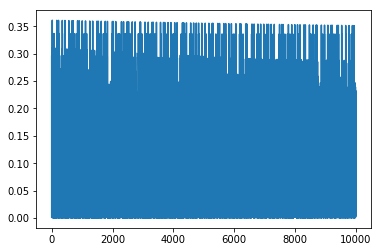

In [18]:
c = stochastique(X, Y, ModuleLinear(2, 1))
plt.plot(range(len(c)), c)
plt.show()

### Batch

In [16]:
def batch(X, Y, module, loss=MSE(), epsilon=0.005, max_iter=100):
    cout = []
    for i in range(max_iter):
        module.zero_grad()
        ypred = module.forward(X)
        delta = loss.backward(Y, ypred)

        module.backward_update_gradient(X, delta)
        module.update_parameters(epsilon=epsilon)

        cout.append(loss.forward(Y, ypred))
    return cout

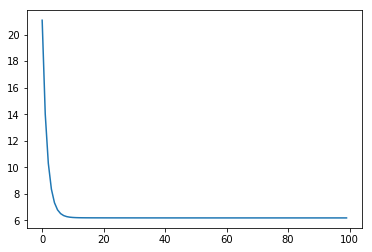

In [20]:
c2 = batch(X, Y, ModuleLinear(2, 1))
plt.plot(range(len(c2)), c2)
plt.show()

### Mini batch

In [15]:
def mini_batch(X, Y, module, loss=MSE(), n=50, epsilon=0.05, max_iter=100):
    cout = []
    for i in range(max_iter):
        inds = list(range(len(X)))[:n]
        np.random.shuffle(inds)

        module.zero_grad()
        
        ypred = module.forward(X[inds])
        delta = loss.backward(Y[inds], ypred)

        module.backward_update_gradient(X[inds], delta)
        module.update_parameters(epsilon=epsilon)

        cout.append(loss.forward(Y[inds], ypred))
            
    return cout

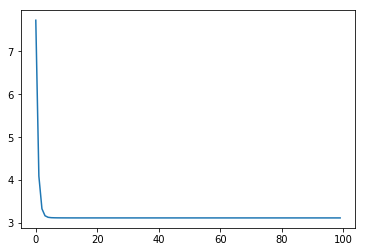

In [22]:
c3 = mini_batch(X, Y, ModuleLinear(2, 1))
plt.plot(range(len(c3)), c3)
plt.show()

### Jeu de données : Boston Housing

In [23]:
with open("housing.data", "r") as f:
    data = pd.read_csv(f, delimiter="\s+", header=None)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


Split de la base afin de créer une base d'apprentissage et de test pour l'évaluation du modèle

In [24]:
X = torch.from_numpy(np.array(data)[:,:-1])
Y = torch.from_numpy(np.array(data)[:,-1]).reshape(-1,1)

# Split
X_train, X_test = X[:int(len(X)*0.7)], X[int(len(X)*0.7):]
Y_train, Y_test = Y[:int(len(Y)*0.7)], Y[int(len(Y)*0.7):]

mse = MSE()

eps1, eps2, eps3 = 1e-9, 1e-10, 1e-4

In [25]:
torch.set_default_tensor_type('torch.DoubleTensor')

Stochastique

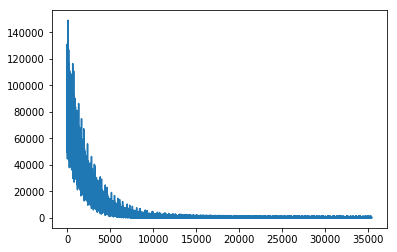

In [26]:
# TRAIN
model = ModuleLinear(len(X[0]), 1)
c = stochastique(X_train, Y_train, model, mse, epsilon=eps1)

plt.plot(range(len(c)), c)
plt.show()

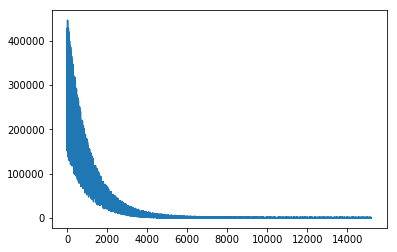

In [27]:
#TEST
model = ModuleLinear(len(X[0]), 1)
c = stochastique(X_test, Y_test, model, mse, epsilon=eps1)

plt.plot(range(len(c)), c)
plt.show()

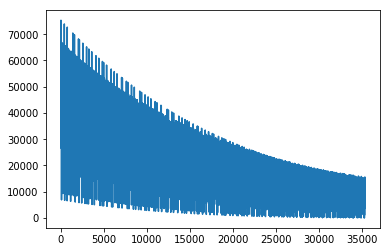

In [28]:
# TRAIN avec epsilon different
c = stochastique(X_train, Y_train, ModuleLinear(len(X[0]), 1), mse, epsilon=eps2)
plt.plot(range(len(c)), c)
plt.show()

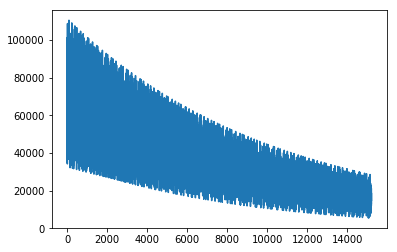

In [29]:
# TEST avec epsilon different
c = stochastique(X_test, Y_test, ModuleLinear(len(X[0]), 1), mse, epsilon=eps2)
plt.plot(range(len(c)), c)
plt.show()

L'erreur en test semble un peu plus élevé qu'en apprentissage mais baisse pareillement.

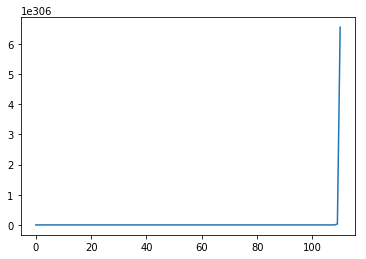

In [30]:
# TRAIN avec un epsilon different
model = ModuleLinear(len(X[0]), 1)
c = stochastique(X_train, Y_train, model, mse, epsilon=eps3)

plt.plot(range(len(c)), c)
plt.show()

Exemple de la courbe en apprentissage avec un epsilon trop grand

Batch

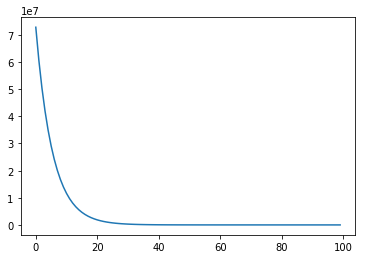

In [31]:
# TRAIN
c = batch(X_train, Y_train, ModuleLinear(len(X[0]), 1), epsilon=eps1)
plt.plot(range(len(c)), c)
plt.show()

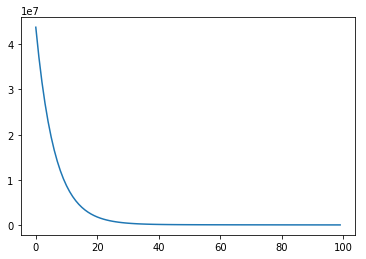

In [32]:
# TEST
c = batch(X_test, Y_test, ModuleLinear(len(X[0]), 1), epsilon=eps1)
plt.plot(range(len(c)), c)
plt.show()

Mini batch

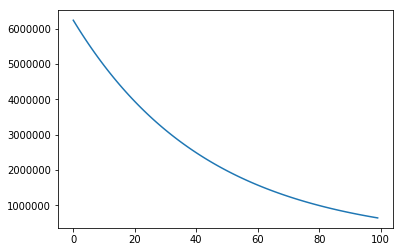

In [33]:
# TRAIN
c = mini_batch(X_train, Y_train, ModuleLinear(len(X[0]), 1), epsilon=eps1)
plt.plot(range(len(c)), c)
plt.show()

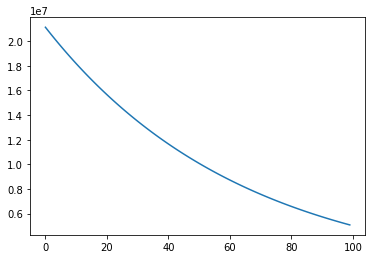

In [34]:
# TEST
c = batch(X_test, Y_test, ModuleLinear(len(X[0]), 1), epsilon=eps2)
plt.plot(range(len(c)), c)
plt.show()

Nous constatons que la version stochastique présente beaucoup d'oscillations tandis que les courbes pour le batch et minibatch sont plus stables et convergent rapidement. De plus, le pas d'apprentissage epsilon semble jouer un rôle capital sur la convergence.

---
## Perceptron

### Jeu de données : MINIST
Chargement des données

In [59]:
## une fois le dataset telecharge, mettre download=False !
## Pour le test, train = False
## transform permet de faire un preprocessing des donnees (ici ?)
batch_size=60000
nb_digits=10
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(), 
                                                                                        transforms.Normalize((0.1307,),
                                                                                                             (0.3081,))])), 
                                           batch_size=batch_size, shuffle=True) 

y_onehot = torch.FloatTensor(batch_size, nb_digits) 

for i,(data,target) in enumerate(train_loader):
    #print(i,data.size(),data.type(),target.size(),
    #   target.type())
    # do something...
    X = data
    print(X.shape)

    print(target.view(-1,1))
    ## Encoding des labels en onehot
    y_onehot.zero_()
    y_onehot.scatter_(1, target.view(-1,1), 1)

    print(y_onehot.shape)
    break
    


torch.Size([60000, 1, 28, 28])
tensor([[2],
        [3],
        [2],
        ...,
        [1],
        [1],
        [5]])
torch.Size([60000, 10])


In [60]:
X = X.reshape(60000,28*28)
Y = y_onehot

In [61]:
X = torch.cat((X[Y[:,0] == 1], X[Y[:,1] == 1], X[Y[:,2] == 1]))
Y = torch.cat((Y[Y[:,0] == 1], Y[Y[:,1] == 1], Y[Y[:,2] == 1]))

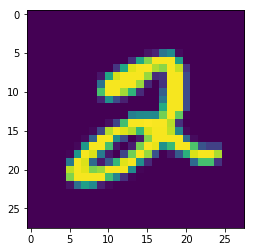

In [5]:
plt.imshow(train_loader.dataset.train_data[5])

### Multi-classes

Stochastique

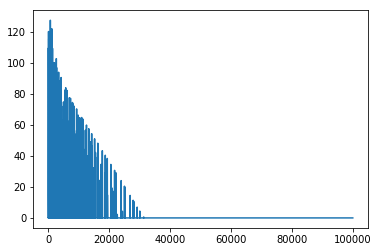

In [17]:
model = ModuleLinear(len(X[0]), 10)
c = stochastique(X, Y, model, Hinge(), epsilon=5e-4)

plt.plot(range(len(c)), c)
plt.show()

Batch

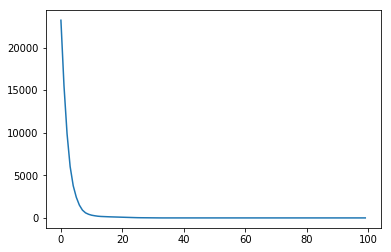

In [18]:
model = ModuleLinear(len(X[0]), 10)
c = batch(X, Y, model, Hinge(), epsilon=5e-4)

plt.plot(range(len(c)), c)
plt.show()

Minibatch

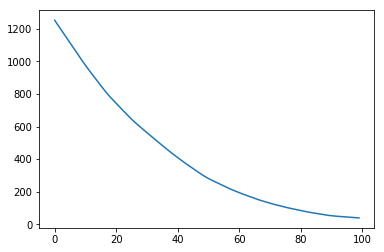

In [19]:
model = ModuleLinear(len(X[0]), 10)
c = mini_batch(X, Y, model, Hinge(), epsilon=5e-4)

plt.plot(range(len(c)), c)
plt.show()

### Binaire

In [20]:
X0 = X[Y[:,0]==1]
Y0 = Y[Y[:,0]==1]

X1 = X[Y[:,1]==1]
Y1 = Y[Y[:,1]==1]

In [21]:
len(X0), len(Y0), len(X1), len(Y1)

(84, 84, 134, 134)

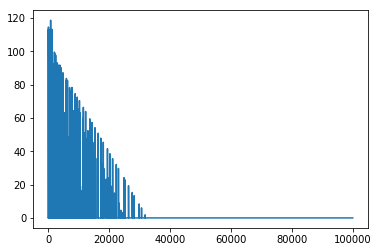

In [22]:
model = ModuleLinear(len(X[0]), 10)
c = stochastique(X, Y, model, Hinge(), epsilon=5e-4)

plt.plot(range(len(c)), c)
plt.show()

---
## Regression logistique et fonction d’activation

### Implémentation

Fonctions d'activation et dérivées

In [35]:
def tanh_g(x):
    return 1-np.tanh(x)**2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_g(x):
    return sigmoid(x)*(1-sigmoid(x))

Régression logistique

In [36]:
class ActivationFunction(Module):
    def __init__(self, fonc, foncg):
        self.fonc = fonc
        self.foncg = foncg
    
    def forward(self, x):
        return self.fonc(x)
    
    def backward_delta(self, x, delta):
        return self.foncg(x)*delta


class CE(Loss):
    # Cross Entropy
    def forward(self, y, ypred):
        #print(( y*np.log(ypred) + (1-y)*np.log(1-ypred) ).sum())
        return ( -1*y*np.log(ypred) - (1-y)*np.log(1-ypred) ).sum()
        
    def backward(self, y, ypred):
        return -1*y/ypred + (1-y)/(1-ypred)

In [37]:
def stochastique(X, Y, module, activ, loss=MSE(), epsilon=0.005, max_iter=10):
    cout = []
    for i in range(max_iter):
        inds = list(range(len(X)))
        np.random.shuffle(inds)
        for x, y in zip(X[inds], Y[inds]):
            x, y = x.reshape(1, -1), y.reshape(1,-1)
            
            module.zero_grad()
            s = module.forward(x)
            ypred = activ.forward(s)
            
            delta = loss.backward(y, ypred)
            delta = activ.backward_delta(s, delta)
            
            module.backward_update_gradient(x, delta)
            module.update_parameters(epsilon=epsilon)
            
            cout.append(loss.forward(y, ypred))
            
    return cout


def batch(X, Y, module, activ, loss=MSE(), epsilon=0.05, max_iter=100):
    cout = []
    for i in range(max_iter):
        module.zero_grad()
        s = module.forward(X)
        ypred = activ.forward(s)

        delta = loss.backward(Y, ypred)
        delta = activ.backward_delta(s, delta)

        module.backward_update_gradient(X, delta)
        module.update_parameters(epsilon=epsilon)

        cout.append(loss.forward(Y, ypred))
    return cout


def mini_batch(X, Y, module, activ, loss=MSE(), n=50, epsilon=0.05, max_iter=100):
    cout = []
    for i in range(max_iter):
        inds = list(range(len(X)))[:n]
        np.random.shuffle(inds)

        module.zero_grad()
        s = module.forward(X[inds])
        ypred = activ.forward(s)

        delta = loss.backward(Y[inds], ypred)
        delta = activ.backward_delta(s, delta)

        module.backward_update_gradient(X[inds], delta)
        module.update_parameters(epsilon=epsilon)

        cout.append(loss.forward(Y[inds], ypred))
            
    return cout

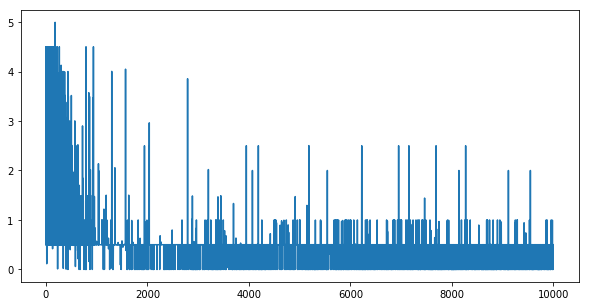

In [60]:
model = ModuleLinear(len(X[0]), 10)
fa = ActivationFunction(sigmoid, sigmoid_g)

c = stochastique(X, Y, model, fa, MSE(), epsilon=3e-1)

plt.figure(figsize=(10, 5))
plt.plot(range(len(c)), c)
plt.show()

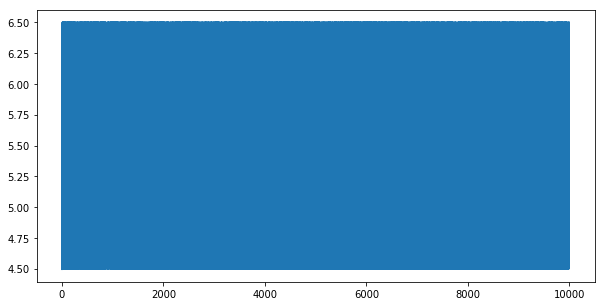

In [85]:
model = ModuleLinear(len(X[0]), 10)
fa = ActivationFunction(np.tanh, tanh_g)

c = stochastique(X, Y, model, fa, MSE(), epsilon=1000000)

plt.figure(figsize=(10, 5))
plt.plot(range(len(c)), c)
plt.show()

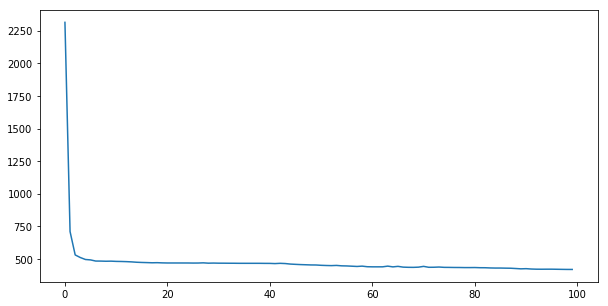

In [42]:
model = ModuleLinear(len(X[0]), 10)
fa = ActivationFunction(sigmoid, sigmoid_g)

c = batch(X, Y, model, fa, MSE(), epsilon=1e-1)

plt.figure(figsize=(10, 5))
plt.plot(range(len(c)), c)
plt.show()

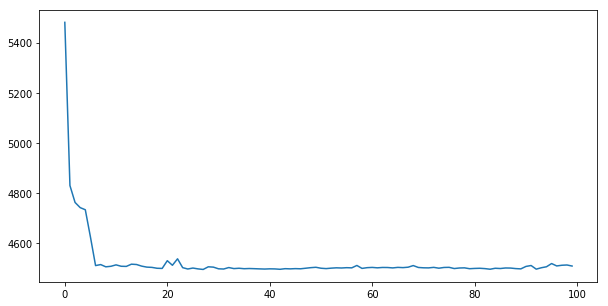

In [64]:
model = ModuleLinear(len(X[0]), 10)
fa = ActivationFunction(np.tanh, tanh_g)

c = batch(X, Y, model, fa, MSE(), epsilon=1e-1)

plt.figure(figsize=(10, 5))
plt.plot(range(len(c)), c)
plt.show()

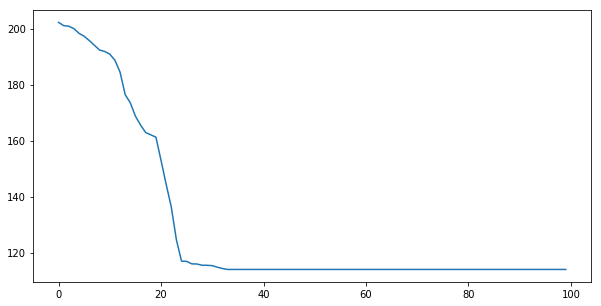

In [51]:
model = ModuleLinear(len(X[0]), 10)
fa = ActivationFunction(sigmoid, sigmoid_g)

c = mini_batch(X, Y, model, fa, MSE(), epsilon=1e-1)

plt.figure(figsize=(10, 5))
plt.plot(range(len(c)), c)
plt.show()

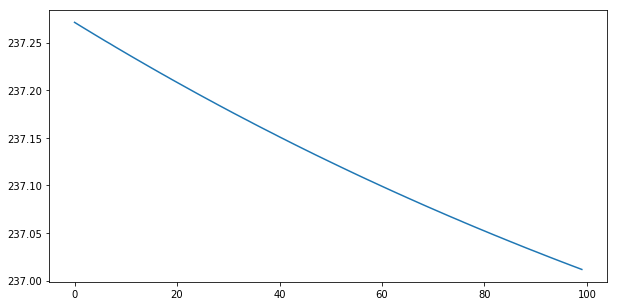

In [52]:
model = ModuleLinear(len(X[0]), 10)
fa = ActivationFunction(np.tanh, tanh_g)

c = mini_batch(X, Y, model, fa, MSE(), epsilon=1e-5)

plt.figure(figsize=(10, 5))
plt.plot(range(len(c)), c)
plt.show()

### Test sur le jeu de données MINIST

In [29]:
def stochastique(X, Y, module, loss=MSE(), epsilon=0.005, max_iter=10):
    cout = []
    for i in range(max_iter):
        inds = list(range(len(X)))
        np.random.shuffle(inds)
        for x, y in zip(X[inds], Y[inds]):
            x, y = x.reshape(1, -1), y.reshape(1,-1)
            module.zero_grad()
            ypred = module.forward(x)
            delta = loss.backward(y, ypred)
            delta = module.backward_delta(x, delta)
            module.backward_update_gradient(x, delta)
            module.update_parameters(epsilon=epsilon)
            
            cout.append(loss.forward(y, ypred))
    return cout

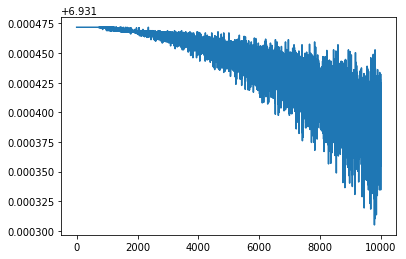

In [17]:
model = RegLog(len(X[0]), 10, sigmoid, sigmoid_g)
c = stochastique(X, Y, model, CE(), epsilon=5e-15)

plt.plot(range(len(c)), c)
plt.show()

In [ ]:
model = RegLog(len(X[0]), 10, sigmoid, sigmoid_g)
c = stochastique(X, Y, model, CE(), epsilon=5e-15)

plt.plot(range(len(c)), c)
plt.show()

In [18]:
def mini_batch(X, Y, module, loss=MSE(), n=50, epsilon=0.05, max_iter=100):
    cout = []
    for i in range(max_iter):
        inds = list(range(len(X)))[:n]
        np.random.shuffle(inds)

        module.zero_grad()
        
        ypred = module.forward(X[inds])
        delta = loss.backward(Y[inds], ypred)
        delta = module.backward_delta(X[inds], delta)
        module.backward_update_gradient(X[inds], delta)
        
        module.update_parameters(epsilon=epsilon)

        cout.append(loss.forward(Y[inds], ypred))
            
    return cout

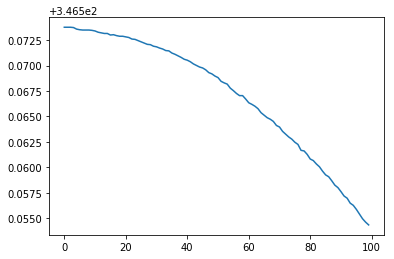

In [22]:
model = RegLog(len(X[0]), 10, sigmoid, sigmoid_g)
c = mini_batch(X, Y, model, CE(), epsilon=5e-12)

plt.plot(range(len(c)), c)
plt.show()

In [39]:
model = RegLog(len(X[0]), 10, sigmoid, sigmoid_g)
c = batch(X, Y, model, CE(), epsilon=5e-8)

plt.plot(range(len(c)), c)
plt.show()

NameError: name 'RegLog' is not defined

# Concatenation

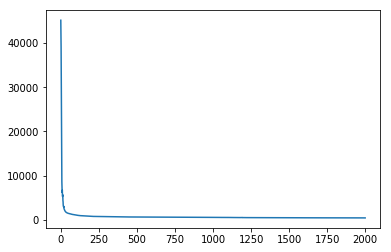

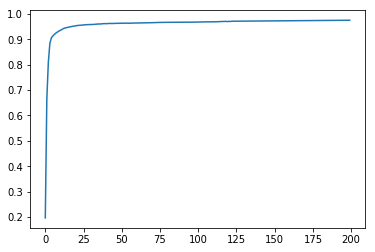

In [62]:
model1 = ModuleLinear(len(X[0]), 15)
activ1 = ActivationFunction(np.tanh, tanh_g)
model2 = ModuleLinear(15, 10)
activ2 = ActivationFunction(sigmoid, sigmoid_g)
loss = MSE()

epsilon=1e-3

cout = []
score = []

for i in range(2000):
    # Initialisation
    model1.zero_grad()
    model2.zero_grad()
    
    s1 = model1.forward(X)
    ypred1 = activ1.forward(s1)
    s2 = model2.forward(ypred1)
    ypred2 = activ2.forward(s2)

    delta2 = loss.backward(Y, ypred2)
    deltas2 = activ2.backward_delta(s2, delta2)

    model2.backward_update_gradient(ypred1, deltas2)
    model2.update_parameters(epsilon=epsilon)
    
    delta1 = model2.backward_delta(ypred1, deltas2)
    deltas1 = activ1.backward_delta(s1, delta1)
    
    model1.backward_update_gradient(X, deltas1)
    model1.update_parameters(epsilon=epsilon)

    cout.append(loss.forward(Y, ypred2))
    
    if i%10 == 0:
        # Calcul du score
        for i in range(len(ypred2)):
            ind = torch.argmax(ypred2[i])
            ypred2[i].zero_()
            ypred2[i][ind] = 1
        tmp = ((ypred2 - Y)**2).sum(1)
        score.append( len(tmp[tmp==0])/len(Y) )
        # -------"""


plt.plot(range(len(cout)), cout)
plt.show()

plt.plot(range(len(score)), score)
plt.show()

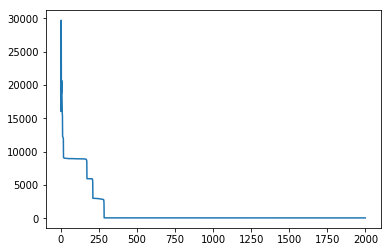

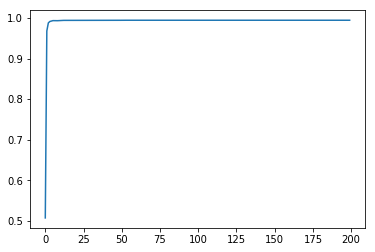

In [57]:
model1 = ModuleLinear(len(X[0]), 15)
activ1 = ActivationFunction(np.tanh, tanh_g)
model2 = ModuleLinear(15, 10)
activ2 = ActivationFunction(sigmoid, sigmoid_g)
loss = MSE()

epsilon=1e-2

cout = []
score = []

for i in range(2000):
    # Initialisation
    model1.zero_grad()
    model2.zero_grad()
    
    s1 = model1.forward(X)
    ypred1 = activ1.forward(s1)
    s2 = model2.forward(ypred1)
    ypred2 = activ2.forward(s2)

    delta2 = loss.backward(Y, ypred2)
    deltas2 = activ2.backward_delta(s2, delta2)

    model2.backward_update_gradient(ypred1, deltas2)
    model2.update_parameters(epsilon=epsilon)
    
    delta1 = model2.backward_delta(ypred1, deltas2)
    deltas1 = activ1.backward_delta(s1, delta1)
    
    model1.backward_update_gradient(X, deltas1)
    model1.update_parameters(epsilon=epsilon)

    cout.append(loss.forward(Y, ypred2))
    
    if i%10 == 0:
        # Calcul du score
        for i in range(len(ypred2)):
            ind = torch.argmax(ypred2[i])
            ypred2[i].zero_()
            ypred2[i][ind] = 1
        tmp = ((ypred2 - Y)**2).sum(1)
        score.append( len(tmp[tmp==0])/len(Y) )
        # -------"""


plt.plot(range(len(cout)), cout)
plt.show()

plt.plot(range(len(score)), score)
plt.show()

In [ ]:
model1 = ModuleLinear(len(X[0]), 15)
activ1 = ActivationFunction(np.tanh, tanh_g)
model2 = ModuleLinear(15, 10)
activ2 = ActivationFunction(sigmoid, sigmoid_g)
loss = MSE()

epsilon=1e-5

cout = []
score = []

for i in range(10):
    ypred = torch.zeros(60000, 10)
    
    inds = list(range(len(X)))
    np.random.shuffle(inds)
    for i, (x, y) in enumerate(zip(X[inds], Y[inds])):
        x, y = x.reshape(1, -1), y.reshape(1,-1)
    
        # Initialisation
        model1.zero_grad()
        model2.zero_grad()

        s1 = model1.forward(x)
        ypred1 = activ1.forward(s1)
        s2 = model2.forward(ypred1)
        ypred2 = activ2.forward(s2)

        delta2 = loss.backward(y, ypred2)
        deltas2 = activ2.backward_delta(s2, delta2)

        model2.backward_update_gradient(ypred1, deltas2)
        model2.update_parameters(epsilon=epsilon)

        delta1 = model2.backward_delta(ypred1, deltas2)
        deltas1 = activ1.backward_delta(s1, delta1)

        model1.backward_update_gradient(x, deltas1)
        model1.update_parameters(epsilon=epsilon)

        ypred[i] = ypred2
        
    cout.append(loss.forward(Y, ypred))
    
    # Calcul du score
    for i in range(len(ypred)):
        ind = torch.argmax(ypred[i])
        ypred[i].zero_()
        ypred[i][ind] = 1
    tmp = ((ypred - Y)**2).sum(1)
    score.append( len(tmp[tmp==0])/len(Y) )
    # -------


plt.plot(range(len(cout)), cout)
plt.show()

plt.plot(range(len(score)), score)
plt.show()